In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-30 12:49:28.798163: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 12:49:29.419117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-30 12:49:29.419201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-30 12:49:29.419209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging/'
background = 50
photons_per_pixel = 400
patch_size = 39
sample = 'full_volume_end_to_end'

learned_lens_data = np.load(data_path + 'full_volume_learned_lens.npy')
single_lens_data = np.load(data_path + 'full_volume_single_lens.npy')
double_lens_data = np.load(data_path + 'full_volume_double_lens.npy')
many_lens_data = np.load(data_path + 'full_volume_many_lens.npy')

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel
learned_lens_data = learned_lens_data / learned_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background
learned_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min(), learned_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max(), learned_lens_data.max())

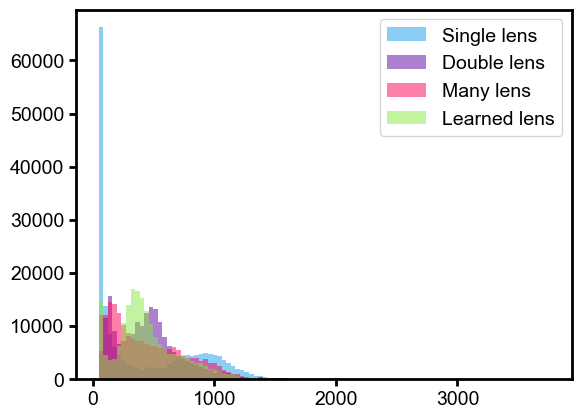

In [3]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5), np.percentile(learned_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
_ = ax.hist(learned_lens_data[:8].ravel(), bins=bins, label='Learned lens', alpha=0.5)
ax.legend()

Text(-30, 80, 'Learned lens')

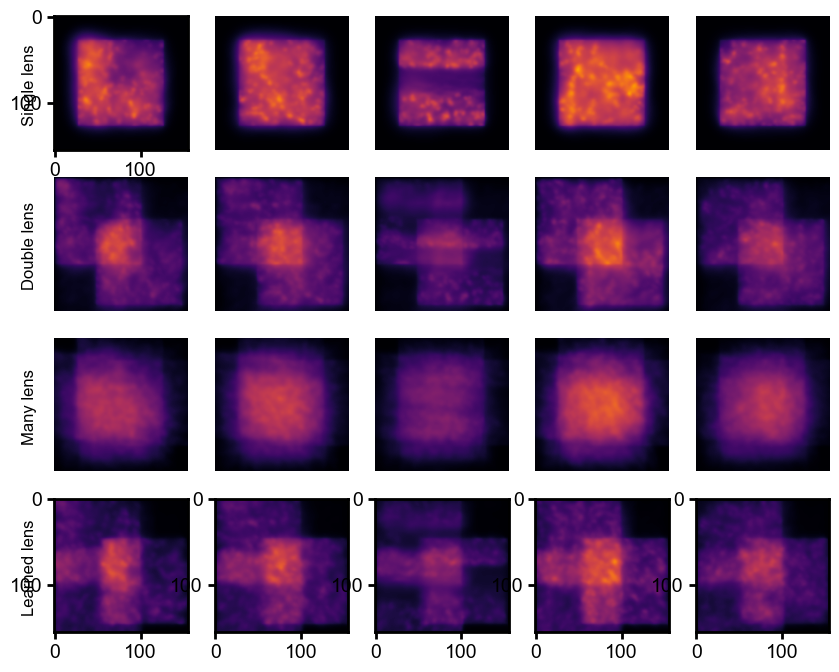

In [8]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data, learned_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data, learned_lens_data]), 99)


fig, axs = plt.subplots(4, 5, figsize=(10, 8))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[3, i].imshow(learned_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

# add text identifying the images to the left of the first column
axs[0, 0].text(-30, 80, 'Single lens', fontsize=12, ha='center', va='center', rotation=90)
axs[1, 0].text(-30, 80, 'Double lens', fontsize=12, ha='center', va='center', rotation=90)
axs[2, 0].text(-30, 80, 'Many lens', fontsize=12, ha='center', va='center', rotation=90)
axs[3, 0].text(-30, 80, 'Learned lens', fontsize=12, ha='center', va='center', rotation=90)

In [9]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


# Generate and train

100%|██████████| 10/10 [00:00<00:00, 118.73it/s]


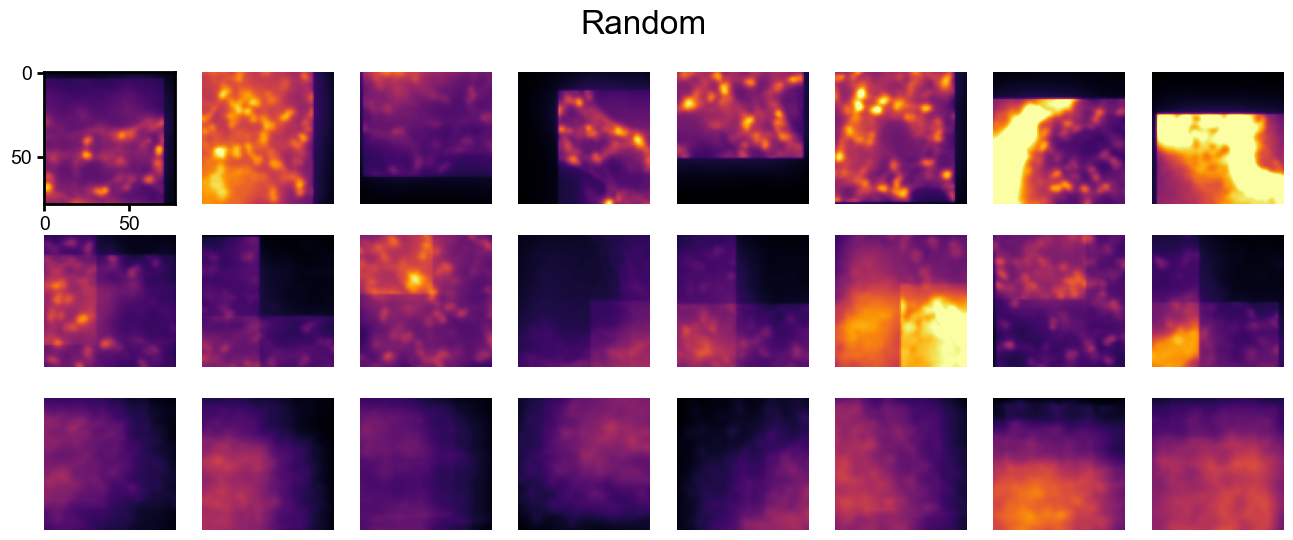

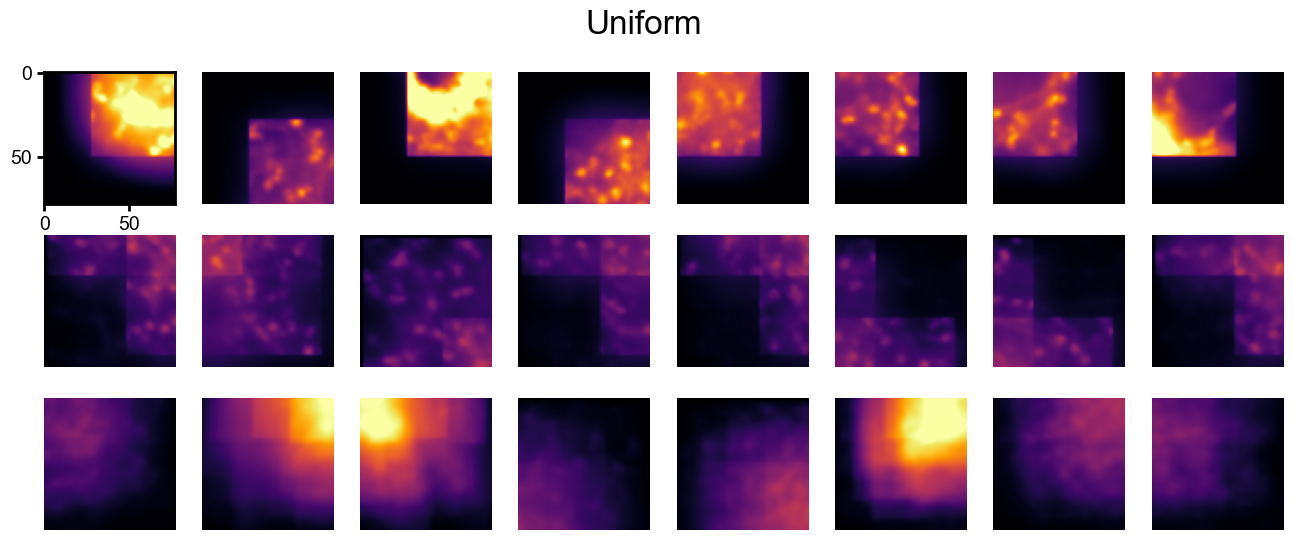

In [3]:
# plot uniform vs center biased patches

# vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
# vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


# for uniform in [False, True]:

#     if uniform:
#         single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#     else:
#         single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

#     fig, axs = plt.subplots(3, 8, figsize=(16, 6))

#     for i in range(8):
#         axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         if i != 0:
#             axs[0, i].axis('off')
#         axs[1, i].axis('off')
#         axs[2, i].axis('off')
#     fig.suptitle('Uniform' if uniform else 'Random')

In [10]:

for i in range(10):

    single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    learned_lens_patches = extract_uniform_patches(learned_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)
    learned_lens_noisy_patches = add_noise(learned_lens_patches)

    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches,entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)
    learned_lens_mi_pcnn = estimate_mutual_information(learned_lens_noisy_patches, clean_images=learned_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # # do gaussian
    # single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    # double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, verbose=True)
    # many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')
    save_data(learned_lens_mi_pcnn, 'pcnn', 'learned_lens')

Initial validation NLL: 346.76


Epoch 1: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 1: validation NLL: 5.98


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.47it/s]


Epoch 2: validation NLL: 5.63


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch 3: validation NLL: 5.85


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.34it/s]


Epoch 4: validation NLL: 6.02


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 5: validation NLL: 5.58


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 6: validation NLL: 6.12


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 7: validation NLL: 5.10


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 8: validation NLL: 4.88


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 10: validation NLL: 5.81


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 11: validation NLL: 7.15


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 12: validation NLL: 7.11


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 13: validation NLL: 6.32


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 14: validation NLL: 7.14


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 15: validation NLL: 7.13


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 16: validation NLL: 7.12


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 17: validation NLL: 7.12


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 18: validation NLL: 7.12


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 19: validation NLL: 7.12


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 20: validation NLL: 7.12


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 21: validation NLL: 7.12


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 22: validation NLL: 7.12


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 23: validation NLL: 7.12


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 24: validation NLL: 7.12


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


Epoch 25: validation NLL: 7.12


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 26: validation NLL: 7.12


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


Epoch 27: validation NLL: 7.12


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 28: validation NLL: 7.12


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 29: validation NLL: 7.12


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 30: validation NLL: 7.12


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 31: validation NLL: 7.12


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 32: validation NLL: 7.12


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 33: validation NLL: 7.12


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 34: validation NLL: 7.12


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 35: validation NLL: 7.12


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 36: validation NLL: 7.12


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 37: validation NLL: 7.12


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 38: validation NLL: 7.12


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 39: validation NLL: 7.12


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 40: validation NLL: 7.12


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 41: validation NLL: 7.12


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 42: validation NLL: 7.12


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 43: validation NLL: 7.12


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 44: validation NLL: 7.12


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 45: validation NLL: 7.12


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 46: validation NLL: 7.12


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 47: validation NLL: 7.12


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 48: validation NLL: 7.12


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 49: validation NLL: 7.12
Estimated H(Y|X) = 4.125 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.611 differential entropy/pixel
Estimated I(Y;X) = 0.701 bits/pixel
Initial validation NLL: 315.01


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


Epoch 1: validation NLL: 5.92


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 2: validation NLL: 5.18


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 3: validation NLL: 5.01


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 4: validation NLL: 4.69


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 5: validation NLL: 4.81


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 6: validation NLL: 4.79


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 9: validation NLL: 4.77


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 10: validation NLL: 4.54


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 11: validation NLL: 4.53


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 12: validation NLL: 4.50


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 17: validation NLL: 4.50


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 18: validation NLL: 4.54


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 20: validation NLL: 4.50


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 21: validation NLL: 4.53


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 22: validation NLL: 4.50


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 23: validation NLL: 4.52


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 25: validation NLL: 4.50


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 26: validation NLL: 4.48


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 27: validation NLL: 4.48


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 28: validation NLL: 4.60


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 29: validation NLL: 4.65


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 30: validation NLL: 4.48


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 31: validation NLL: 4.47


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 32: validation NLL: 4.52


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 33: validation NLL: 4.52


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 34: validation NLL: 4.51


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 35: validation NLL: 4.49


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 36: validation NLL: 4.49


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 37: validation NLL: 4.49


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 38: validation NLL: 4.47


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 39: validation NLL: 4.61


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 40: validation NLL: 4.55


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 41: validation NLL: 4.47


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 43: validation NLL: 4.50


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 45: validation NLL: 4.46


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 46: validation NLL: 4.51


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 48: validation NLL: 4.50


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 49: validation NLL: 4.48


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 52: validation NLL: 4.49


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 54: validation NLL: 4.52


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 55: validation NLL: 4.47


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 56: validation NLL: 4.52


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 57: validation NLL: 4.53


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 58: validation NLL: 4.49


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 59: validation NLL: 4.48


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 60: validation NLL: 4.47


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 61: validation NLL: 4.56


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 62: validation NLL: 4.66


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 63: validation NLL: 4.50


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 64: validation NLL: 4.51


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 65: validation NLL: 4.47


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 66: validation NLL: 4.47


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 67: validation NLL: 4.47


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 68: validation NLL: 4.48


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 70: validation NLL: 4.47


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 71: validation NLL: 4.46


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 72: validation NLL: 4.47


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 73: validation NLL: 4.48


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 74: validation NLL: 4.48


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 75: validation NLL: 4.47


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 76: validation NLL: 4.46


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 77: validation NLL: 4.47


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 79: validation NLL: 4.45


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 80: validation NLL: 4.49


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 81: validation NLL: 4.45


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 82: validation NLL: 4.45


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 83: validation NLL: 4.47


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 84: validation NLL: 4.49


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 85: validation NLL: 4.45


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 86: validation NLL: 4.46


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 87: validation NLL: 4.47


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 89: validation NLL: 4.49


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 90: validation NLL: 4.50


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 91: validation NLL: 4.45


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 92: validation NLL: 4.49


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 93: validation NLL: 4.46


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 94: validation NLL: 4.47


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 95: validation NLL: 4.44


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 96: validation NLL: 4.50


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 97: validation NLL: 4.47


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 98: validation NLL: 4.46


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 99: validation NLL: 4.45


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 100: validation NLL: 4.46


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 101: validation NLL: 5.11


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 102: validation NLL: 5.46


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 103: validation NLL: 6.70


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 104: validation NLL: 6.69


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 105: validation NLL: 6.69


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 106: validation NLL: 6.69


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 107: validation NLL: 6.69


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 108: validation NLL: 6.69


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 109: validation NLL: 6.69


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 110: validation NLL: 6.69


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 111: validation NLL: 6.69


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 112: validation NLL: 6.69


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 113: validation NLL: 6.69


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 114: validation NLL: 6.69


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 115: validation NLL: 6.69


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 116: validation NLL: 6.69


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 117: validation NLL: 6.69


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 118: validation NLL: 6.69


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 119: validation NLL: 6.69


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 120: validation NLL: 6.69


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 121: validation NLL: 6.69


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 122: validation NLL: 6.69


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 123: validation NLL: 6.69


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 124: validation NLL: 6.69


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 125: validation NLL: 6.69


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 126: validation NLL: 6.69


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 127: validation NLL: 6.69


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 128: validation NLL: 6.69


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 129: validation NLL: 6.69


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 130: validation NLL: 6.69


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 131: validation NLL: 6.69


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 132: validation NLL: 6.69


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 133: validation NLL: 6.69


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 134: validation NLL: 6.69


Epoch 135: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 135: validation NLL: 6.69
Estimated H(Y|X) = 4.346 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.471 differential entropy/pixel
Estimated I(Y;X) = 0.181 bits/pixel
Initial validation NLL: 310.84


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Epoch 1: validation NLL: 6.02


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 2: validation NLL: 5.56


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 3: validation NLL: 4.90


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 4: validation NLL: 5.11


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 5: validation NLL: 4.79


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 6: validation NLL: 4.66


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 7: validation NLL: 4.71


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 11: validation NLL: 4.50


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 14: validation NLL: 4.48


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 15: validation NLL: 4.48


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 16: validation NLL: 4.47


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 18: validation NLL: 4.50


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 20: validation NLL: 4.80


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 21: validation NLL: 4.53


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 23: validation NLL: 4.49


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 24: validation NLL: 4.47


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 26: validation NLL: 4.46


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 27: validation NLL: 4.48


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 28: validation NLL: 4.47


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 30: validation NLL: 4.46


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 31: validation NLL: 4.46


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 35: validation NLL: 4.52


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 36: validation NLL: 4.54


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 37: validation NLL: 4.46


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 40: validation NLL: 4.50


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 41: validation NLL: 4.63


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 42: validation NLL: 4.69


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 43: validation NLL: 4.55


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 46: validation NLL: 4.46


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 48: validation NLL: 4.44


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 49: validation NLL: 4.44


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 50: validation NLL: 4.58


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 52: validation NLL: 4.43


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 55: validation NLL: 4.44


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 57: validation NLL: 4.49


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 59: validation NLL: 4.57


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 60: validation NLL: 4.65


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 61: validation NLL: 4.46


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 63: validation NLL: 4.56


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 64: validation NLL: 4.44


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 66: validation NLL: 4.44


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 67: validation NLL: 4.44


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 68: validation NLL: 4.46


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 70: validation NLL: 4.44


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 71: validation NLL: 4.43


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 72: validation NLL: 4.45


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 73: validation NLL: 4.44


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 74: validation NLL: 4.46


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 75: validation NLL: 4.46


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 76: validation NLL: 4.49


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 77: validation NLL: 4.48


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 78: validation NLL: 4.44


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 79: validation NLL: 4.42


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 80: validation NLL: 4.43


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 81: validation NLL: 4.46


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 82: validation NLL: 4.63


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 83: validation NLL: 4.43


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 84: validation NLL: 4.44


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 85: validation NLL: 4.43


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 86: validation NLL: 4.62


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 87: validation NLL: 4.46


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 88: validation NLL: 4.45


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 89: validation NLL: 4.42


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 90: validation NLL: 4.43


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 91: validation NLL: 4.49


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 92: validation NLL: 4.42


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 93: validation NLL: 4.43


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 94: validation NLL: 4.42


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 95: validation NLL: 4.44


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 96: validation NLL: 4.46


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 97: validation NLL: 4.42


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 98: validation NLL: 4.45


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 99: validation NLL: 4.42


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 100: validation NLL: 4.44


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 101: validation NLL: 4.44


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 102: validation NLL: 4.43


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 103: validation NLL: 4.43


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 104: validation NLL: 4.44


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 105: validation NLL: 4.44


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 106: validation NLL: 4.42


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 107: validation NLL: 4.43


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 108: validation NLL: 4.85


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 109: validation NLL: 5.18


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 110: validation NLL: 5.88


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 111: validation NLL: 7.73


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 112: validation NLL: 6.86


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 113: validation NLL: 6.86


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 114: validation NLL: 6.86


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 115: validation NLL: 6.86


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 116: validation NLL: 6.86


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 117: validation NLL: 6.86


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 118: validation NLL: 6.86


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 119: validation NLL: 6.86


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 120: validation NLL: 6.86


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 121: validation NLL: 6.86


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 122: validation NLL: 6.86


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 123: validation NLL: 6.86


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 124: validation NLL: 6.86


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 125: validation NLL: 6.86


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 126: validation NLL: 6.86


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 127: validation NLL: 6.86


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 128: validation NLL: 6.86


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 129: validation NLL: 6.86


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 130: validation NLL: 6.86


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 131: validation NLL: 6.86


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 132: validation NLL: 6.86


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 133: validation NLL: 6.86


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 134: validation NLL: 6.86
Estimated H(Y|X) = 4.302 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.419 differential entropy/pixel
Estimated I(Y;X) = 0.168 bits/pixel
Initial validation NLL: 298.83


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


Epoch 1: validation NLL: 5.53


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 2: validation NLL: 5.19


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 3: validation NLL: 4.95


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 4: validation NLL: 4.85


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 5: validation NLL: 5.18


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 6: validation NLL: 4.68


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 7: validation NLL: 4.68


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 8: validation NLL: 4.80


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 10: validation NLL: 5.06


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 11: validation NLL: 5.37


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 12: validation NLL: 4.63


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 14: validation NLL: 5.03


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 15: validation NLL: 4.86


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 16: validation NLL: 4.78


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 17: validation NLL: 4.77


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 18: validation NLL: 5.48


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 19: validation NLL: 4.91


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 20: validation NLL: 4.89


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 23: validation NLL: 4.55


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 25: validation NLL: 4.56


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 26: validation NLL: 4.57


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 28: validation NLL: 4.52


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 29: validation NLL: 4.51


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 30: validation NLL: 4.62


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 31: validation NLL: 4.60


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 32: validation NLL: 4.57


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 33: validation NLL: 4.78


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 34: validation NLL: 4.55


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 36: validation NLL: 4.58


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 37: validation NLL: 4.55


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 38: validation NLL: 4.60


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 40: validation NLL: 4.51


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 41: validation NLL: 4.59


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 42: validation NLL: 4.56


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 43: validation NLL: 4.61


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 44: validation NLL: 4.54


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 45: validation NLL: 4.57


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 46: validation NLL: 4.62


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 47: validation NLL: 4.58


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 49: validation NLL: 4.64


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 50: validation NLL: 4.54


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 51: validation NLL: 4.59


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 52: validation NLL: 4.51


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 53: validation NLL: 4.66


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 54: validation NLL: 4.52


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 55: validation NLL: 4.52


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 56: validation NLL: 4.53


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 57: validation NLL: 4.54


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 58: validation NLL: 5.26


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 59: validation NLL: 5.00


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 60: validation NLL: 5.06


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 61: validation NLL: 4.63


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 62: validation NLL: 4.59


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 63: validation NLL: 4.56


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 64: validation NLL: 4.65


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 65: validation NLL: 4.54


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 66: validation NLL: 4.57


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 67: validation NLL: 4.57


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 68: validation NLL: 4.56


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 69: validation NLL: 4.54


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 70: validation NLL: 4.53


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 71: validation NLL: 4.61


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 72: validation NLL: 4.52


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 73: validation NLL: 4.64


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 74: validation NLL: 4.52


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 75: validation NLL: 4.53


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 76: validation NLL: 4.58


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 77: validation NLL: 4.55


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 78: validation NLL: 4.79


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 79: validation NLL: 4.58


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 80: validation NLL: 4.54
Estimated H(Y|X) = 4.353 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.512 differential entropy/pixel
Estimated I(Y;X) = 0.229 bits/pixel
Initial validation NLL: 341.35


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


Epoch 1: validation NLL: 6.38


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 2: validation NLL: 6.18


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 3: validation NLL: 6.30


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 4: validation NLL: 5.50


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 5: validation NLL: 5.26


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 6: validation NLL: 6.10


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 7: validation NLL: 6.72


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 8: validation NLL: 7.49


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 9: validation NLL: 7.12


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 10: validation NLL: 7.07


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 11: validation NLL: 7.06


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 12: validation NLL: 7.06


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 13: validation NLL: 7.06


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 14: validation NLL: 7.03


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 15: validation NLL: 7.07


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 16: validation NLL: 7.06


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 17: validation NLL: 7.06


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 18: validation NLL: 7.06


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 19: validation NLL: 7.06


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 20: validation NLL: 7.06


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 21: validation NLL: 7.05


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 22: validation NLL: 7.05


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 23: validation NLL: 7.05


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 24: validation NLL: 7.05


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 25: validation NLL: 7.05


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 26: validation NLL: 7.05


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 27: validation NLL: 7.05


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 28: validation NLL: 7.05


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 29: validation NLL: 7.05


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 30: validation NLL: 7.05


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 31: validation NLL: 7.05


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 32: validation NLL: 7.05


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 33: validation NLL: 7.05


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 34: validation NLL: 7.05


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 35: validation NLL: 7.05


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 36: validation NLL: 7.06


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 37: validation NLL: 7.06


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 38: validation NLL: 7.06


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 39: validation NLL: 7.06


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 40: validation NLL: 7.05


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 41: validation NLL: 7.05


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 42: validation NLL: 7.05


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 43: validation NLL: 7.05


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 44: validation NLL: 7.05


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 45: validation NLL: 7.05
Estimated H(Y|X) = 4.121 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.306 differential entropy/pixel
Estimated I(Y;X) = 1.710 bits/pixel
Initial validation NLL: 340.45


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


Epoch 1: validation NLL: 6.12


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 2: validation NLL: 5.27


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 3: validation NLL: 5.76


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 4: validation NLL: 4.92


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 5: validation NLL: 5.45


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 6: validation NLL: 5.12


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 7: validation NLL: 4.83


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 8: validation NLL: 4.84


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 9: validation NLL: 4.84


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 10: validation NLL: 4.68


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 11: validation NLL: 6.22


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 12: validation NLL: 4.78


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 13: validation NLL: 4.65


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 14: validation NLL: 4.71


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 15: validation NLL: 4.65


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 16: validation NLL: 4.65


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 17: validation NLL: 4.56


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 19: validation NLL: 4.60


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 20: validation NLL: 4.64


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 21: validation NLL: 4.66


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 22: validation NLL: 4.68


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 23: validation NLL: 4.60


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 26: validation NLL: 4.60


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 27: validation NLL: 4.82


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 28: validation NLL: 4.66


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 29: validation NLL: 4.60


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 30: validation NLL: 4.57


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 31: validation NLL: 4.67


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 32: validation NLL: 4.62


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 33: validation NLL: 4.55


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 34: validation NLL: 4.54


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 35: validation NLL: 4.59


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 36: validation NLL: 4.59


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 37: validation NLL: 4.57


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 38: validation NLL: 4.71


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 39: validation NLL: 4.54


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 40: validation NLL: 4.69


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 41: validation NLL: 4.61


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 42: validation NLL: 4.59


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 43: validation NLL: 4.55


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 44: validation NLL: 4.54


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 45: validation NLL: 4.55


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 46: validation NLL: 4.55


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 47: validation NLL: 4.54


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 48: validation NLL: 4.60


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 49: validation NLL: 4.59


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 51: validation NLL: 4.54


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 53: validation NLL: 4.53


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 54: validation NLL: 4.53


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 55: validation NLL: 4.56


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 56: validation NLL: 4.53


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 57: validation NLL: 4.52


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 58: validation NLL: 4.79


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 59: validation NLL: 4.67


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 60: validation NLL: 4.56


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 61: validation NLL: 4.59


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 62: validation NLL: 4.51


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 63: validation NLL: 4.52


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 64: validation NLL: 4.52


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 65: validation NLL: 4.58


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 66: validation NLL: 4.55


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 67: validation NLL: 4.70


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 68: validation NLL: 4.54


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 69: validation NLL: 4.53


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 70: validation NLL: 4.76


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 71: validation NLL: 4.84


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 72: validation NLL: 4.57


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 73: validation NLL: 4.75


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 74: validation NLL: 4.53


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 75: validation NLL: 4.56


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 76: validation NLL: 4.56


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 77: validation NLL: 4.63


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 78: validation NLL: 4.53


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 79: validation NLL: 4.53


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 80: validation NLL: 4.52


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 81: validation NLL: 4.59


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 82: validation NLL: 4.54


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 83: validation NLL: 4.54


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 84: validation NLL: 4.65


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 85: validation NLL: 4.59


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 86: validation NLL: 4.52


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 87: validation NLL: 4.52


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 88: validation NLL: 4.53


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 89: validation NLL: 4.52


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 90: validation NLL: 4.52


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 91: validation NLL: 4.53


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 92: validation NLL: 4.52


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 94: validation NLL: 4.55


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 95: validation NLL: 4.57


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 96: validation NLL: 4.53


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 97: validation NLL: 4.56


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 98: validation NLL: 4.52


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 99: validation NLL: 4.52


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 100: validation NLL: 4.57


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 101: validation NLL: 4.56


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 102: validation NLL: 4.53
Estimated H(Y|X) = 4.353 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.500 differential entropy/pixel
Estimated I(Y;X) = 0.213 bits/pixel
Initial validation NLL: 338.47


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Epoch 1: validation NLL: 6.27


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 2: validation NLL: 5.77


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 3: validation NLL: 5.31


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 4: validation NLL: 5.33


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 5: validation NLL: 5.12


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 6: validation NLL: 4.72


Epoch 7: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Epoch 7: validation NLL: 4.89


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 8: validation NLL: 4.72


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 9: validation NLL: 4.92


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


Epoch 10: validation NLL: 5.06


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 11: validation NLL: 5.04


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 12: validation NLL: 4.67


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 13: validation NLL: 4.53


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 14: validation NLL: 4.60


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 16: validation NLL: 5.14


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 18: validation NLL: 4.71


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 19: validation NLL: 4.56


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 20: validation NLL: 4.51


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.57it/s]


Epoch 21: validation NLL: 5.07


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch 22: validation NLL: 5.11


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 23: validation NLL: 4.77


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 24: validation NLL: 4.59


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 25: validation NLL: 5.33


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 26: validation NLL: 4.65


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.53it/s]


Epoch 27: validation NLL: 4.64


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 29: validation NLL: 4.63


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 30: validation NLL: 4.77


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 31: validation NLL: 4.55


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


Epoch 33: validation NLL: 4.54


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.56it/s]


Epoch 34: validation NLL: 4.50


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 37: validation NLL: 4.49


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 38: validation NLL: 4.53


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.60it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.59it/s]


Epoch 40: validation NLL: 4.58


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.61it/s]


Epoch 41: validation NLL: 4.60


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 43: validation NLL: 4.61


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 44: validation NLL: 4.54


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 45: validation NLL: 4.56


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 47: validation NLL: 4.51


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 48: validation NLL: 4.55


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 49: validation NLL: 4.58


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 51: validation NLL: 4.49


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 52: validation NLL: 4.50


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 53: validation NLL: 4.48


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 54: validation NLL: 4.65


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 55: validation NLL: 4.46


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 56: validation NLL: 4.48


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 57: validation NLL: 4.57


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 58: validation NLL: 4.48


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 59: validation NLL: 4.48


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 60: validation NLL: 4.49


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 62: validation NLL: 4.56


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 63: validation NLL: 4.72


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 64: validation NLL: 5.24


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 65: validation NLL: 4.48


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 66: validation NLL: 4.61


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 67: validation NLL: 4.51


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 68: validation NLL: 4.67


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 69: validation NLL: 4.52


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 70: validation NLL: 4.49


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 71: validation NLL: 4.58


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 72: validation NLL: 4.47


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 73: validation NLL: 4.53


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 74: validation NLL: 4.47


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 75: validation NLL: 4.48


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 76: validation NLL: 4.51


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 77: validation NLL: 4.49


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 79: validation NLL: 4.48


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 80: validation NLL: 4.51


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 81: validation NLL: 4.47


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 82: validation NLL: 4.50


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 83: validation NLL: 4.49


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 84: validation NLL: 4.49


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 85: validation NLL: 4.56


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 86: validation NLL: 4.68


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 87: validation NLL: 4.47


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 88: validation NLL: 4.47


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 89: validation NLL: 4.48


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 90: validation NLL: 4.49


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 91: validation NLL: 4.46


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 92: validation NLL: 4.50


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 93: validation NLL: 4.51


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 94: validation NLL: 4.60


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 95: validation NLL: 4.48


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 96: validation NLL: 4.48


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 97: validation NLL: 4.65


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 98: validation NLL: 4.46


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 99: validation NLL: 4.47


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 100: validation NLL: 4.46


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 101: validation NLL: 4.47


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 102: validation NLL: 4.47


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 103: validation NLL: 4.46


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 104: validation NLL: 4.47


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 105: validation NLL: 4.46


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 106: validation NLL: 4.50


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 107: validation NLL: 4.47


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 108: validation NLL: 4.46


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 109: validation NLL: 4.47


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 110: validation NLL: 4.46


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 111: validation NLL: 4.46


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 112: validation NLL: 4.58


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 113: validation NLL: 5.17


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 114: validation NLL: 6.93


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 115: validation NLL: 6.92


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 116: validation NLL: 6.92


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 117: validation NLL: 6.92


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 118: validation NLL: 6.92


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 119: validation NLL: 6.92


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 120: validation NLL: 6.92


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 121: validation NLL: 6.92


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 122: validation NLL: 6.92


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 123: validation NLL: 6.92


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 124: validation NLL: 6.92


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 125: validation NLL: 6.92


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 126: validation NLL: 6.92


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 127: validation NLL: 6.92


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 128: validation NLL: 6.92


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 129: validation NLL: 6.92


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 130: validation NLL: 6.92


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 131: validation NLL: 6.92


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 132: validation NLL: 6.92


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 133: validation NLL: 6.92


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 134: validation NLL: 6.92


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 135: validation NLL: 6.92


Epoch 136: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 136: validation NLL: 6.92


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 137: validation NLL: 6.92


Epoch 138: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 138: validation NLL: 6.92


Epoch 139: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 139: validation NLL: 6.92


Epoch 140: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 140: validation NLL: 6.92


Epoch 141: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 141: validation NLL: 6.92


Epoch 142: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 142: validation NLL: 6.92


Epoch 143: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 143: validation NLL: 6.92


Epoch 144: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 144: validation NLL: 6.92


Epoch 145: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 145: validation NLL: 6.92


Epoch 146: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 146: validation NLL: 6.92


Epoch 147: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 147: validation NLL: 6.92


Epoch 148: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 148: validation NLL: 6.92


Epoch 149: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 149: validation NLL: 6.92


Epoch 150: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 150: validation NLL: 6.92
Estimated H(Y|X) = 4.315 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.423 differential entropy/pixel
Estimated I(Y;X) = 0.156 bits/pixel
Initial validation NLL: 248.87


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Epoch 1: validation NLL: 6.36


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 2: validation NLL: 6.41


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 3: validation NLL: 5.86


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 4: validation NLL: 5.20


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 5: validation NLL: 4.98


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 6: validation NLL: 4.95


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 8: validation NLL: 4.68


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 12: validation NLL: 4.57


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 14: validation NLL: 4.56


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 15: validation NLL: 4.64


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 16: validation NLL: 4.66


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 21: validation NLL: 4.56


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 22: validation NLL: 4.55


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 23: validation NLL: 4.52


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


Epoch 24: validation NLL: 4.62


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 27: validation NLL: 4.65


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 28: validation NLL: 4.84


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.64it/s]


Epoch 29: validation NLL: 4.63


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.63it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 32: validation NLL: 4.79


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 33: validation NLL: 4.52


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 34: validation NLL: 4.54


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 36: validation NLL: 4.86


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 37: validation NLL: 4.55


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 38: validation NLL: 4.50


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 39: validation NLL: 4.57


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 40: validation NLL: 4.50


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 44: validation NLL: 4.54


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 45: validation NLL: 4.61


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 46: validation NLL: 4.49


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 48: validation NLL: 4.73


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 49: validation NLL: 4.68


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 50: validation NLL: 4.52


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 51: validation NLL: 4.53


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 52: validation NLL: 4.51


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 53: validation NLL: 4.52


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 55: validation NLL: 4.78


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 56: validation NLL: 4.49


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 57: validation NLL: 4.52


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 58: validation NLL: 4.49


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 59: validation NLL: 4.48


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 60: validation NLL: 4.58


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 61: validation NLL: 4.62


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 62: validation NLL: 4.52


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 63: validation NLL: 4.48


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 64: validation NLL: 4.49


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 65: validation NLL: 4.51


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 66: validation NLL: 4.48


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 67: validation NLL: 4.50


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 68: validation NLL: 4.55


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 69: validation NLL: 5.41


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 25.36it/s]


Epoch 70: validation NLL: 4.63


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


Epoch 71: validation NLL: 4.59


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 25.39it/s]


Epoch 72: validation NLL: 4.60


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 73: validation NLL: 4.54


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 74: validation NLL: 4.58


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 75: validation NLL: 4.57


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 76: validation NLL: 4.68


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 77: validation NLL: 4.54


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 78: validation NLL: 4.54


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 79: validation NLL: 4.57


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.40it/s]


Epoch 80: validation NLL: 4.52


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 81: validation NLL: 4.54


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 82: validation NLL: 4.56


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 83: validation NLL: 4.52


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Epoch 84: validation NLL: 4.51


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 85: validation NLL: 4.53


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 86: validation NLL: 4.53


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 87: validation NLL: 4.57


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 88: validation NLL: 4.51


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.41it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Epoch 90: validation NLL: 4.54


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 91: validation NLL: 4.55


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Epoch 92: validation NLL: 4.51


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 93: validation NLL: 4.50


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 25.42it/s]


Epoch 94: validation NLL: 4.49
Estimated H(Y|X) = 4.355 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.511 differential entropy/pixel
Estimated I(Y;X) = 0.225 bits/pixel
Initial validation NLL: 374.88


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.04it/s]


Epoch 1: validation NLL: 5.98


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


Epoch 2: validation NLL: 6.06


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 3: validation NLL: 5.49


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 4: validation NLL: 5.21


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


Epoch 5: validation NLL: 5.26


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 6: validation NLL: 5.55


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 7: validation NLL: 5.52


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 8: validation NLL: 5.17


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 9: validation NLL: 4.94


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 10: validation NLL: 6.51


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 11: validation NLL: 4.95


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 12: validation NLL: 4.55


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 13: validation NLL: 4.46


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 14: validation NLL: 4.43


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 15: validation NLL: 4.40


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 16: validation NLL: 4.39


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 17: validation NLL: 4.46


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 18: validation NLL: 4.39


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 19: validation NLL: 4.37


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 20: validation NLL: 4.39


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 21: validation NLL: 4.32


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 22: validation NLL: 4.32


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 23: validation NLL: 4.71


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 24: validation NLL: 4.32


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 25: validation NLL: 4.37


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 26: validation NLL: 4.38


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 27: validation NLL: 4.33


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 28: validation NLL: 4.37


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 29: validation NLL: 4.35


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 30: validation NLL: 4.34


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 31: validation NLL: 4.34


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 32: validation NLL: 4.34


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 33: validation NLL: 4.31


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 34: validation NLL: 4.30


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 35: validation NLL: 4.32


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 36: validation NLL: 4.42


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 37: validation NLL: 4.29


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 38: validation NLL: 4.32


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 39: validation NLL: 4.32


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 40: validation NLL: 4.32


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 41: validation NLL: 4.29


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 42: validation NLL: 4.30


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 43: validation NLL: 4.33


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 44: validation NLL: 4.30


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 45: validation NLL: 4.28


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 46: validation NLL: 4.30


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 47: validation NLL: 4.29


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 48: validation NLL: 4.30


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 49: validation NLL: 4.28


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 50: validation NLL: 4.34


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 51: validation NLL: 4.30


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 52: validation NLL: 4.29


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 53: validation NLL: 4.31


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 54: validation NLL: 4.27


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 55: validation NLL: 4.27


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 56: validation NLL: 4.27


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 57: validation NLL: 4.28


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 58: validation NLL: 6.19


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 59: validation NLL: 4.83


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 60: validation NLL: 4.66


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 61: validation NLL: 4.35


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 62: validation NLL: 4.34


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 63: validation NLL: 4.34


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 64: validation NLL: 4.48


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 65: validation NLL: 4.35


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 66: validation NLL: 4.30


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 67: validation NLL: 4.29


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 68: validation NLL: 4.31


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 69: validation NLL: 4.35


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 70: validation NLL: 4.30


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 71: validation NLL: 4.31


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 72: validation NLL: 4.50


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 73: validation NLL: 4.28


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 74: validation NLL: 4.39


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 75: validation NLL: 4.32


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 76: validation NLL: 4.28


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 77: validation NLL: 4.32


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 78: validation NLL: 4.28


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 79: validation NLL: 4.30


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 80: validation NLL: 4.30


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 81: validation NLL: 4.29


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 82: validation NLL: 4.28


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 83: validation NLL: 4.30


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 84: validation NLL: 4.28


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 85: validation NLL: 4.29


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 86: validation NLL: 4.38


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 87: validation NLL: 4.32


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 88: validation NLL: 4.32


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 89: validation NLL: 4.27


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 90: validation NLL: 4.28


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 91: validation NLL: 4.29


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 92: validation NLL: 4.28


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 93: validation NLL: 4.28


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 94: validation NLL: 4.27


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 95: validation NLL: 4.34


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 96: validation NLL: 4.27


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 97: validation NLL: 4.26


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 98: validation NLL: 4.29


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 99: validation NLL: 4.28


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 100: validation NLL: 4.36


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 101: validation NLL: 4.29


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 102: validation NLL: 4.29


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 103: validation NLL: 4.30


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 104: validation NLL: 4.26


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 105: validation NLL: 4.27


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 106: validation NLL: 4.31


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 107: validation NLL: 4.28


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 108: validation NLL: 4.25


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 109: validation NLL: 4.30


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 110: validation NLL: 4.28


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 111: validation NLL: 4.28


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 112: validation NLL: 4.27


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 113: validation NLL: 4.29


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 114: validation NLL: 4.31


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 115: validation NLL: 4.33


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 116: validation NLL: 4.25


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 117: validation NLL: 4.26


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 118: validation NLL: 4.42


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 119: validation NLL: 4.25


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 120: validation NLL: 4.27


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 121: validation NLL: 4.27


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 122: validation NLL: 4.27


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 123: validation NLL: 4.26


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 124: validation NLL: 4.27


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 125: validation NLL: 4.28


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 126: validation NLL: 4.28


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 127: validation NLL: 4.28


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 128: validation NLL: 4.26


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 129: validation NLL: 4.25


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 130: validation NLL: 4.28


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 131: validation NLL: 4.93


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 132: validation NLL: 7.14


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 133: validation NLL: 7.13


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 134: validation NLL: 7.13


Epoch 135: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 135: validation NLL: 7.13


Epoch 136: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 136: validation NLL: 7.13


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 137: validation NLL: 7.13


Epoch 138: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 138: validation NLL: 7.13


Epoch 139: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 139: validation NLL: 7.13


Epoch 140: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 140: validation NLL: 7.13


Epoch 141: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 141: validation NLL: 7.13


Epoch 142: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 142: validation NLL: 7.13


Epoch 143: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 143: validation NLL: 7.13


Epoch 144: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 144: validation NLL: 7.13


Epoch 145: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 145: validation NLL: 7.13


Epoch 146: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 146: validation NLL: 7.13


Epoch 147: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 147: validation NLL: 7.13


Epoch 148: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 148: validation NLL: 7.13


Epoch 149: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 149: validation NLL: 7.13


Epoch 150: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 150: validation NLL: 7.13


Epoch 151: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 151: validation NLL: 7.13


Epoch 152: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 152: validation NLL: 7.13


Epoch 153: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 153: validation NLL: 7.13


Epoch 154: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 154: validation NLL: 7.13


Epoch 155: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 155: validation NLL: 7.13


Epoch 156: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 156: validation NLL: 7.13


Epoch 157: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 157: validation NLL: 7.13


Epoch 158: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 158: validation NLL: 7.13


Epoch 159: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 159: validation NLL: 7.13


Epoch 160: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 160: validation NLL: 7.13


Epoch 161: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 161: validation NLL: 7.13


Epoch 162: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 162: validation NLL: 7.13


Epoch 163: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 163: validation NLL: 7.13


Epoch 164: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 164: validation NLL: 7.13


Epoch 165: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 165: validation NLL: 7.13


Epoch 166: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 166: validation NLL: 7.13


Epoch 167: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 167: validation NLL: 7.13


Epoch 168: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 168: validation NLL: 7.13


Epoch 169: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 169: validation NLL: 7.13
Estimated H(Y|X) = 4.127 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.237 differential entropy/pixel
Estimated I(Y;X) = 0.159 bits/pixel
Initial validation NLL: 316.38


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.94it/s]


Epoch 1: validation NLL: 5.79


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 2: validation NLL: 5.50


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 3: validation NLL: 4.95


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 4: validation NLL: 5.53


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 5: validation NLL: 4.99


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 6: validation NLL: 5.58


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 7: validation NLL: 4.80


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 8: validation NLL: 4.70


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 10: validation NLL: 5.01


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 11: validation NLL: 4.65


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 12: validation NLL: 6.30


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 13: validation NLL: 5.43


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 14: validation NLL: 5.00


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 18: validation NLL: 4.91


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 19: validation NLL: 4.59


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 21: validation NLL: 4.63


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 22: validation NLL: 4.59


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 24: validation NLL: 4.53


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 25: validation NLL: 4.56


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 26: validation NLL: 4.87


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 27: validation NLL: 4.53


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 28: validation NLL: 5.16


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 29: validation NLL: 5.35


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 30: validation NLL: 4.83


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 31: validation NLL: 4.65


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 33: validation NLL: 4.72


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 34: validation NLL: 4.59


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 35: validation NLL: 4.59


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 37: validation NLL: 4.71


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 38: validation NLL: 4.64


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 39: validation NLL: 4.52


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 40: validation NLL: 4.59


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 41: validation NLL: 4.63


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 42: validation NLL: 4.63


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 43: validation NLL: 4.66


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 44: validation NLL: 4.56


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 45: validation NLL: 4.56


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 46: validation NLL: 4.53


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 47: validation NLL: 4.67


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 48: validation NLL: 4.68


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 51: validation NLL: 4.66


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 52: validation NLL: 4.56


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 53: validation NLL: 4.65


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 54: validation NLL: 4.57


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 55: validation NLL: 4.56


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 56: validation NLL: 6.27


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 57: validation NLL: 6.70


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 58: validation NLL: 6.70


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 59: validation NLL: 6.70


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 60: validation NLL: 6.70


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 61: validation NLL: 6.69


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 62: validation NLL: 6.70


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 63: validation NLL: 6.70


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 64: validation NLL: 6.68


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 65: validation NLL: 6.56


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 66: validation NLL: 5.36


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 67: validation NLL: 5.88


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 68: validation NLL: 5.25


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 69: validation NLL: 4.84


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 70: validation NLL: 4.81


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 71: validation NLL: 4.63


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 72: validation NLL: 4.69


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 73: validation NLL: 4.62


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 74: validation NLL: 4.56


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 75: validation NLL: 4.60


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 76: validation NLL: 4.57


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 77: validation NLL: 4.55


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 78: validation NLL: 4.54


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 79: validation NLL: 4.55


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 80: validation NLL: 4.56


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 81: validation NLL: 4.55


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 82: validation NLL: 4.54


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 83: validation NLL: 4.55


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 84: validation NLL: 4.55


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 85: validation NLL: 4.55


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 86: validation NLL: 4.60


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 87: validation NLL: 4.54


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 89: validation NLL: 4.58


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 90: validation NLL: 4.53


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 91: validation NLL: 4.58


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 92: validation NLL: 4.54


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 94: validation NLL: 4.55


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 95: validation NLL: 4.54


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 96: validation NLL: 4.52


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 97: validation NLL: 4.59


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 98: validation NLL: 4.52


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 99: validation NLL: 4.54


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 100: validation NLL: 4.94


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 101: validation NLL: 4.59


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 102: validation NLL: 4.53


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 103: validation NLL: 4.54


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 104: validation NLL: 4.56


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 105: validation NLL: 4.57


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 106: validation NLL: 4.55


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 107: validation NLL: 4.52


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 108: validation NLL: 4.58


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 109: validation NLL: 4.53


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 110: validation NLL: 4.52


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 111: validation NLL: 4.53


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 112: validation NLL: 4.54


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 113: validation NLL: 4.53


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 114: validation NLL: 4.55


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 115: validation NLL: 4.55


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 116: validation NLL: 4.52


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 117: validation NLL: 4.51


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 118: validation NLL: 4.61


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 119: validation NLL: 4.51


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 120: validation NLL: 4.53


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 121: validation NLL: 4.52


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 122: validation NLL: 4.56


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 123: validation NLL: 4.50


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 124: validation NLL: 4.51


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 125: validation NLL: 4.52


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 126: validation NLL: 4.50


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 127: validation NLL: 4.51


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 128: validation NLL: 4.51


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 129: validation NLL: 4.53


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 130: validation NLL: 4.55


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 131: validation NLL: 4.50


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 132: validation NLL: 4.52


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 133: validation NLL: 4.63


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 134: validation NLL: 4.62


Epoch 135: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 135: validation NLL: 4.54


Epoch 136: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 136: validation NLL: 4.53


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 137: validation NLL: 4.52


Epoch 138: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 138: validation NLL: 5.00


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 139: validation NLL: 4.61


Epoch 140: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 140: validation NLL: 4.53


Epoch 141: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 141: validation NLL: 4.53


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 142: validation NLL: 4.54


Epoch 143: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 143: validation NLL: 4.52


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 144: validation NLL: 4.52


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 145: validation NLL: 4.52


Epoch 146: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 146: validation NLL: 4.57


Epoch 147: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 147: validation NLL: 4.50


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 148: validation NLL: 4.53


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 149: validation NLL: 4.53


Epoch 150: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 150: validation NLL: 4.51


Epoch 151: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 151: validation NLL: 4.52


Epoch 152: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 152: validation NLL: 4.53


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 153: validation NLL: 4.53


Epoch 154: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 154: validation NLL: 4.50


Epoch 155: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 155: validation NLL: 4.56


Epoch 156: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 156: validation NLL: 4.50


Epoch 157: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 157: validation NLL: 4.51


Epoch 158: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 158: validation NLL: 4.50


Epoch 159: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 159: validation NLL: 4.51


Epoch 160: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 160: validation NLL: 4.50


Epoch 161: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 161: validation NLL: 4.51


Epoch 162: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 162: validation NLL: 4.54


Epoch 163: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 163: validation NLL: 4.50


Epoch 164: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 164: validation NLL: 4.49


Epoch 165: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 165: validation NLL: 4.51


Epoch 166: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 166: validation NLL: 4.49


Epoch 167: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 167: validation NLL: 4.51


Epoch 168: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 168: validation NLL: 4.52


Epoch 169: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 169: validation NLL: 4.49


Epoch 170: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 170: validation NLL: 4.50


Epoch 171: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 171: validation NLL: 4.51


Epoch 172: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 172: validation NLL: 4.49


Epoch 173: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 173: validation NLL: 4.50


Epoch 174: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 174: validation NLL: 4.50


Epoch 175: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 175: validation NLL: 4.49


Epoch 176: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 176: validation NLL: 4.51


Epoch 177: 100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


Epoch 177: validation NLL: 4.51


Epoch 178: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


Epoch 178: validation NLL: 4.49


Epoch 179: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 179: validation NLL: 4.51


Epoch 180: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 180: validation NLL: 4.52


Epoch 181: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 181: validation NLL: 4.51


Epoch 182: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 182: validation NLL: 4.53


Epoch 183: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 183: validation NLL: 4.49


Epoch 184: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 184: validation NLL: 4.52


Epoch 185: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 185: validation NLL: 4.49


Epoch 186: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 186: validation NLL: 4.53


Epoch 187: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 187: validation NLL: 4.51


Epoch 188: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 188: validation NLL: 4.50


Epoch 189: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 189: validation NLL: 4.49


Epoch 190: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 190: validation NLL: 4.50


Epoch 191: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 191: validation NLL: 4.50


Epoch 192: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 192: validation NLL: 4.51


Epoch 193: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 193: validation NLL: 4.53


Epoch 194: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 194: validation NLL: 4.49


Epoch 195: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 195: validation NLL: 4.51


Epoch 196: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 196: validation NLL: 4.54


Epoch 197: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 197: validation NLL: 4.51


Epoch 198: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 198: validation NLL: 4.50


Epoch 199: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 199: validation NLL: 4.50


Epoch 200: 100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


Epoch 200: validation NLL: 4.49
Estimated H(Y|X) = 4.336 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.478 differential entropy/pixel
Estimated I(Y;X) = 0.204 bits/pixel
Initial validation NLL: 349.31


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


Epoch 1: validation NLL: 5.74


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 2: validation NLL: 5.42


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 3: validation NLL: 5.28


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 4: validation NLL: 4.89


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 5: validation NLL: 5.68


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 6: validation NLL: 4.84


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 7: validation NLL: 5.34


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 8: validation NLL: 5.71


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 9: validation NLL: 4.71


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 10: validation NLL: 4.78


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 11: validation NLL: 4.82


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 12: validation NLL: 4.67


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 13: validation NLL: 4.56


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 14: validation NLL: 4.65


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 15: validation NLL: 4.64


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 16: validation NLL: 4.55


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 17: validation NLL: 4.67


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 19: validation NLL: 5.31


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 20: validation NLL: 4.75


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 23: validation NLL: 4.69


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 24: validation NLL: 4.66


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 25: validation NLL: 4.66


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 27: validation NLL: 4.70


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 28: validation NLL: 4.79


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 29: validation NLL: 4.83


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 30: validation NLL: 4.82


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 31: validation NLL: 4.69


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 32: validation NLL: 4.65


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 35: validation NLL: 4.86


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 36: validation NLL: 4.59


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 37: validation NLL: 4.64


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 38: validation NLL: 4.47


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 39: validation NLL: 4.50


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 40: validation NLL: 4.57


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 41: validation NLL: 4.60


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 42: validation NLL: 4.47


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 43: validation NLL: 4.56


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 44: validation NLL: 4.46


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 45: validation NLL: 4.86


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 46: validation NLL: 4.48


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 47: validation NLL: 4.47


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 48: validation NLL: 4.65


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 49: validation NLL: 4.64


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 50: validation NLL: 4.49


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 51: validation NLL: 4.62


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 52: validation NLL: 4.49


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 53: validation NLL: 4.46


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 54: validation NLL: 4.58


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 55: validation NLL: 4.47


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 56: validation NLL: 4.50


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 57: validation NLL: 4.49


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 58: validation NLL: 4.68


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 59: validation NLL: 4.50


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 60: validation NLL: 4.46


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 62: validation NLL: 4.45


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 63: validation NLL: 4.45


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 64: validation NLL: 4.61


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 65: validation NLL: 6.78


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 66: validation NLL: 6.89


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 67: validation NLL: 5.98


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 68: validation NLL: 5.20


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 69: validation NLL: 4.92


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 70: validation NLL: 4.92


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 71: validation NLL: 4.62


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 72: validation NLL: 4.63


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 73: validation NLL: 4.55


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 74: validation NLL: 4.58


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 75: validation NLL: 4.55


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 76: validation NLL: 4.53


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 77: validation NLL: 4.52


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 78: validation NLL: 4.53


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 79: validation NLL: 4.52


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 80: validation NLL: 4.54


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 81: validation NLL: 4.57


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 82: validation NLL: 4.64


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 83: validation NLL: 4.51


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 84: validation NLL: 4.50


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 25.27it/s]


Epoch 85: validation NLL: 4.49


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


Epoch 86: validation NLL: 4.50


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 87: validation NLL: 4.51


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Epoch 89: validation NLL: 4.52


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 90: validation NLL: 4.49


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 91: validation NLL: 4.54


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Epoch 92: validation NLL: 4.51


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 93: validation NLL: 4.54


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 94: validation NLL: 4.59


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


Epoch 95: validation NLL: 4.51


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


Epoch 96: validation NLL: 4.54


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 25.26it/s]


Epoch 97: validation NLL: 4.48


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 98: validation NLL: 4.56


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 99: validation NLL: 4.55


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 25.29it/s]


Epoch 100: validation NLL: 4.54


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]


Epoch 101: validation NLL: 4.48


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 25.28it/s]


Epoch 102: validation NLL: 5.12
Estimated H(Y|X) = 4.302 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.401 differential entropy/pixel
Estimated I(Y;X) = 0.144 bits/pixel
Initial validation NLL: 285.53


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Epoch 1: validation NLL: 5.95


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.20it/s]


Epoch 2: validation NLL: 5.45


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


Epoch 3: validation NLL: 5.27


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 4: validation NLL: 5.13


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 5: validation NLL: 5.22


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 6: validation NLL: 4.89


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 7: validation NLL: 5.35


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 8: validation NLL: 4.64


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 11: validation NLL: 4.76


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 12: validation NLL: 4.94


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 14: validation NLL: 5.15


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 17: validation NLL: 4.63


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 18: validation NLL: 4.61


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 19: validation NLL: 4.66


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 22: validation NLL: 4.66


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 23: validation NLL: 4.66


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 24: validation NLL: 4.79


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 26: validation NLL: 4.72


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 27: validation NLL: 4.55


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 30: validation NLL: 4.66


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 31: validation NLL: 4.61


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 32: validation NLL: 4.63


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 33: validation NLL: 4.56


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 35: validation NLL: 4.58


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 36: validation NLL: 4.57


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 37: validation NLL: 4.58


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 38: validation NLL: 5.88


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 39: validation NLL: 4.68


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 40: validation NLL: 4.59


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 41: validation NLL: 4.65


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 42: validation NLL: 4.58


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 43: validation NLL: 4.65


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 44: validation NLL: 4.66


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 45: validation NLL: 4.57


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 46: validation NLL: 4.55


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 47: validation NLL: 4.53


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 48: validation NLL: 4.53


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 49: validation NLL: 4.55


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 50: validation NLL: 4.56


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 51: validation NLL: 4.54


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 53: validation NLL: 4.55


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 54: validation NLL: 4.57


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 56: validation NLL: 4.59


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 57: validation NLL: 4.55


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 58: validation NLL: 4.53


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 59: validation NLL: 4.56


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 60: validation NLL: 4.52


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 61: validation NLL: 4.52


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 62: validation NLL: 4.59


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 63: validation NLL: 4.59


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 64: validation NLL: 4.60


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 65: validation NLL: 4.59


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 66: validation NLL: 4.53


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 67: validation NLL: 4.52


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


Epoch 68: validation NLL: 4.69


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 69: validation NLL: 4.58


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 70: validation NLL: 4.54


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 71: validation NLL: 4.60


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 72: validation NLL: 4.54


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 73: validation NLL: 4.57


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 74: validation NLL: 4.57


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 75: validation NLL: 4.53


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 77: validation NLL: 4.52


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 78: validation NLL: 4.53


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 79: validation NLL: 4.54


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 80: validation NLL: 4.57


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


Epoch 81: validation NLL: 4.55


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 82: validation NLL: 4.56


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 83: validation NLL: 4.56


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 84: validation NLL: 4.52


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 85: validation NLL: 4.52


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 86: validation NLL: 4.52


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 87: validation NLL: 4.53


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 88: validation NLL: 4.53


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 89: validation NLL: 4.52


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 90: validation NLL: 4.71


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 91: validation NLL: 4.56


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 92: validation NLL: 4.52


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 94: validation NLL: 4.51


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 95: validation NLL: 4.53


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 96: validation NLL: 4.52


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 97: validation NLL: 4.59


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 98: validation NLL: 4.51


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 99: validation NLL: 4.51


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 100: validation NLL: 4.51


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 101: validation NLL: 4.58


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 102: validation NLL: 4.54


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 103: validation NLL: 4.51


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 104: validation NLL: 4.52


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 105: validation NLL: 4.51


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 106: validation NLL: 4.62


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 107: validation NLL: 4.52


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 108: validation NLL: 4.52


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 109: validation NLL: 4.54


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 110: validation NLL: 4.53


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 111: validation NLL: 4.54


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 112: validation NLL: 4.52


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 113: validation NLL: 4.61


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 114: validation NLL: 4.51


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 115: validation NLL: 5.03


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 116: validation NLL: 6.74


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 117: validation NLL: 6.69


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 118: validation NLL: 6.74


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 119: validation NLL: 6.73


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 120: validation NLL: 6.73


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 121: validation NLL: 6.73


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 122: validation NLL: 6.73


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 123: validation NLL: 6.73


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 124: validation NLL: 6.73


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 125: validation NLL: 6.73


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 126: validation NLL: 6.73


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 127: validation NLL: 6.73


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 128: validation NLL: 6.73


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 129: validation NLL: 6.73


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 130: validation NLL: 6.73


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 131: validation NLL: 6.73


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 132: validation NLL: 6.73


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 133: validation NLL: 6.73


Epoch 134: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 134: validation NLL: 6.73


Epoch 135: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 135: validation NLL: 6.73


Epoch 136: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 136: validation NLL: 6.73


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 137: validation NLL: 6.73


Epoch 138: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]


Epoch 138: validation NLL: 6.73


Epoch 139: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 139: validation NLL: 6.73


Epoch 140: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 140: validation NLL: 6.73


Epoch 141: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 141: validation NLL: 6.73


Epoch 142: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 142: validation NLL: 6.73


Epoch 143: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 143: validation NLL: 6.73


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 144: validation NLL: 6.73


Epoch 145: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 145: validation NLL: 6.73


Epoch 146: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 146: validation NLL: 6.73


Epoch 147: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 147: validation NLL: 6.73


Epoch 148: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 148: validation NLL: 6.73


Epoch 149: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 149: validation NLL: 6.73


Epoch 150: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 150: validation NLL: 6.73


Epoch 151: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 151: validation NLL: 6.73


Epoch 152: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 152: validation NLL: 6.73


Epoch 153: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 153: validation NLL: 6.73


Epoch 154: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 154: validation NLL: 6.73
Estimated H(Y|X) = 4.360 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.481 differential entropy/pixel
Estimated I(Y;X) = 0.175 bits/pixel
Initial validation NLL: 364.18


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.56it/s]


Epoch 1: validation NLL: 6.53


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.18it/s]


Epoch 2: validation NLL: 6.04


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.17it/s]


Epoch 3: validation NLL: 6.02


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.15it/s]


Epoch 4: validation NLL: 5.92


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 5: validation NLL: 5.94


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 6: validation NLL: 5.24


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 7: validation NLL: 4.91


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 9: validation NLL: 4.48


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 10: validation NLL: 4.43


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 11: validation NLL: 4.35


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 12: validation NLL: 4.40


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 13: validation NLL: 4.31


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 14: validation NLL: 4.31


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 15: validation NLL: 4.37


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 16: validation NLL: 4.28


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 17: validation NLL: 4.35


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 19: validation NLL: 4.48


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 20: validation NLL: 4.27


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 21: validation NLL: 4.27


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 22: validation NLL: 4.33


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 23: validation NLL: 4.30


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 24: validation NLL: 4.28


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 25: validation NLL: 4.31


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 26: validation NLL: 4.33


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 27: validation NLL: 4.24


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 28: validation NLL: 4.30


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 29: validation NLL: 4.27


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 30: validation NLL: 4.30


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 31: validation NLL: 4.26


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 32: validation NLL: 4.32


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 33: validation NLL: 4.40


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 34: validation NLL: 4.25


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 35: validation NLL: 4.28


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 36: validation NLL: 4.25


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 37: validation NLL: 4.24


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 38: validation NLL: 4.26


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 39: validation NLL: 4.26


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 40: validation NLL: 4.26


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 41: validation NLL: 4.26


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 42: validation NLL: 4.25


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 43: validation NLL: 4.26


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 44: validation NLL: 4.24


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 45: validation NLL: 4.25


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 46: validation NLL: 4.28


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 47: validation NLL: 4.25


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 48: validation NLL: 4.24


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 49: validation NLL: 4.25


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 50: validation NLL: 4.26


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 51: validation NLL: 4.25


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 52: validation NLL: 4.25


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 53: validation NLL: 4.48


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 54: validation NLL: 4.26


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 55: validation NLL: 4.25


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 56: validation NLL: 4.29


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 57: validation NLL: 4.28


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 58: validation NLL: 4.26


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 59: validation NLL: 4.26


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 60: validation NLL: 4.27


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 61: validation NLL: 4.26


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 62: validation NLL: 4.27


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 63: validation NLL: 4.23


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 64: validation NLL: 4.23


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 65: validation NLL: 4.23


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 66: validation NLL: 4.27


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 67: validation NLL: 4.28


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 68: validation NLL: 4.26


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 69: validation NLL: 4.25


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 70: validation NLL: 4.27


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.79it/s]


Epoch 71: validation NLL: 4.26


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 72: validation NLL: 4.27


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 73: validation NLL: 4.24


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 74: validation NLL: 4.25


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 75: validation NLL: 4.26


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 76: validation NLL: 4.24


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 77: validation NLL: 4.25


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 78: validation NLL: 4.27


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 79: validation NLL: 4.24


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 80: validation NLL: 4.28


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 81: validation NLL: 4.25


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 82: validation NLL: 4.25


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 83: validation NLL: 4.24


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 84: validation NLL: 4.24


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 85: validation NLL: 4.22


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 86: validation NLL: 4.28


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 87: validation NLL: 4.25


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 88: validation NLL: 4.24


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 89: validation NLL: 4.23


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 90: validation NLL: 4.34


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 91: validation NLL: 4.24


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 92: validation NLL: 4.22


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 93: validation NLL: 4.24


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 94: validation NLL: 4.23


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 95: validation NLL: 4.24


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 96: validation NLL: 4.24


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 97: validation NLL: 4.29


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 98: validation NLL: 4.24


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 99: validation NLL: 4.32


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 100: validation NLL: 4.25


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 101: validation NLL: 4.25


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 102: validation NLL: 4.26


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 103: validation NLL: 4.25


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 104: validation NLL: 4.22


Epoch 105: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 105: validation NLL: 4.23


Epoch 106: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 106: validation NLL: 4.30


Epoch 107: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 107: validation NLL: 4.24


Epoch 108: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 108: validation NLL: 4.24


Epoch 109: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 109: validation NLL: 4.25


Epoch 110: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 110: validation NLL: 4.24


Epoch 111: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 111: validation NLL: 4.24


Epoch 112: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 112: validation NLL: 4.27


Epoch 113: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 113: validation NLL: 4.25


Epoch 114: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 114: validation NLL: 4.23


Epoch 115: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 115: validation NLL: 4.22


Epoch 116: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 116: validation NLL: 4.23


Epoch 117: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 117: validation NLL: 4.26


Epoch 118: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 118: validation NLL: 4.28


Epoch 119: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 119: validation NLL: 4.28


Epoch 120: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 120: validation NLL: 4.30


Epoch 121: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 121: validation NLL: 4.33


Epoch 122: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 122: validation NLL: 4.24


Epoch 123: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 123: validation NLL: 4.25


Epoch 124: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 124: validation NLL: 4.26


Epoch 125: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 125: validation NLL: 4.26


Epoch 126: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 126: validation NLL: 4.25


Epoch 127: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 127: validation NLL: 4.33


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 128: validation NLL: 4.28


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 129: validation NLL: 4.25


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 130: validation NLL: 6.48


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 131: validation NLL: 7.14


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 132: validation NLL: 7.22
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.186 differential entropy/pixel
Estimated I(Y;X) = 0.082 bits/pixel
Initial validation NLL: 330.69


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


Epoch 1: validation NLL: 5.66


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 2: validation NLL: 5.36


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 3: validation NLL: 4.92


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Epoch 4: validation NLL: 5.02


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]


Epoch 5: validation NLL: 4.68


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 6: validation NLL: 5.03


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.08it/s]


Epoch 7: validation NLL: 4.70


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.97it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 13: validation NLL: 4.56


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 14: validation NLL: 4.52


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 15: validation NLL: 4.54


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 16: validation NLL: 4.50


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 17: validation NLL: 4.54


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 18: validation NLL: 4.51


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 19: validation NLL: 4.51


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 22: validation NLL: 4.52


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 23: validation NLL: 4.54


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 24: validation NLL: 4.62


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 25: validation NLL: 4.53


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 26: validation NLL: 4.52


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 27: validation NLL: 4.56


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Epoch 28: validation NLL: 4.49


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 29: validation NLL: 4.53


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 30: validation NLL: 4.50


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.65it/s]


Epoch 32: validation NLL: 4.52


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.67it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.68it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 35: validation NLL: 4.55


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


Epoch 36: validation NLL: 5.49


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.69it/s]


Epoch 37: validation NLL: 6.24


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 38: validation NLL: 6.69


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 39: validation NLL: 6.67


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 40: validation NLL: 6.66


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 41: validation NLL: 6.66


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 42: validation NLL: 6.66


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 43: validation NLL: 6.66


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 44: validation NLL: 6.66


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 45: validation NLL: 6.66


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 46: validation NLL: 6.66


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 47: validation NLL: 6.66


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 48: validation NLL: 6.66


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 49: validation NLL: 6.66


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 50: validation NLL: 6.66


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 51: validation NLL: 6.66


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 52: validation NLL: 6.66


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 53: validation NLL: 6.66


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 54: validation NLL: 6.66


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 55: validation NLL: 6.66


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 56: validation NLL: 6.66


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 57: validation NLL: 6.66


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 58: validation NLL: 6.66


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 59: validation NLL: 6.66


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 60: validation NLL: 6.66


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 61: validation NLL: 6.66


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 62: validation NLL: 6.66


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 63: validation NLL: 6.66


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 64: validation NLL: 6.66


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 65: validation NLL: 6.66


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 66: validation NLL: 6.66


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 67: validation NLL: 6.66


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 68: validation NLL: 6.66


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 69: validation NLL: 6.66


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 70: validation NLL: 6.66


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 71: validation NLL: 6.66


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 72: validation NLL: 6.66


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 73: validation NLL: 6.66
Estimated H(Y|X) = 4.348 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.507 differential entropy/pixel
Estimated I(Y;X) = 0.229 bits/pixel
Initial validation NLL: 327.92


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


Epoch 1: validation NLL: 6.34


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 25.16it/s]


Epoch 2: validation NLL: 6.23


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 3: validation NLL: 5.97


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 25.14it/s]


Epoch 4: validation NLL: 5.70


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 5: validation NLL: 5.21


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


Epoch 6: validation NLL: 4.88


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 25.12it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 9: validation NLL: 4.48


Epoch 10: 100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


Epoch 10: validation NLL: 4.49


Epoch 11: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 12: validation NLL: 4.56


Epoch 13: 100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 15: validation NLL: 4.44


Epoch 16: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 16: validation NLL: 4.48


Epoch 17: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


Epoch 19: validation NLL: 4.48


Epoch 20: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


Epoch 20: validation NLL: 4.46


Epoch 21: 100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


Epoch 21: validation NLL: 4.52


Epoch 22: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 22: validation NLL: 4.46


Epoch 23: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 23: validation NLL: 4.46


Epoch 24: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 24: validation NLL: 4.44


Epoch 25: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 26: validation NLL: 4.45


Epoch 27: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 27: validation NLL: 4.50


Epoch 28: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 28: validation NLL: 4.67


Epoch 29: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 29: validation NLL: 4.44


Epoch 30: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 30: validation NLL: 4.51


Epoch 31: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 33: validation NLL: 4.45


Epoch 34: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 37: validation NLL: 4.44


Epoch 38: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 38: validation NLL: 4.49


Epoch 39: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 39: validation NLL: 4.47


Epoch 40: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 40: validation NLL: 4.44


Epoch 41: 100%|██████████| 100/100 [00:04<00:00, 24.75it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 43: validation NLL: 4.51


Epoch 44: 100%|██████████| 100/100 [00:04<00:00, 24.74it/s]


Epoch 44: validation NLL: 4.74


Epoch 45: 100%|██████████| 100/100 [00:04<00:00, 24.76it/s]


Epoch 45: validation NLL: 4.79


Epoch 46: 100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


Epoch 47: validation NLL: 4.80


Epoch 48: 100%|██████████| 100/100 [00:04<00:00, 24.82it/s]


Epoch 48: validation NLL: 4.49


Epoch 49: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 50: validation NLL: 4.43


Epoch 51: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 51: validation NLL: 4.46


Epoch 52: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 52: validation NLL: 4.45


Epoch 53: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 54: validation NLL: 4.45


Epoch 55: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 55: validation NLL: 4.77


Epoch 56: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 56: validation NLL: 4.45


Epoch 57: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:04<00:00, 24.91it/s]


Epoch 58: validation NLL: 4.44


Epoch 59: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 59: validation NLL: 4.45


Epoch 60: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 60: validation NLL: 4.44


Epoch 61: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 61: validation NLL: 4.44


Epoch 62: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 63: validation NLL: 4.42


Epoch 64: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


Epoch 64: validation NLL: 4.43


Epoch 65: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 65: validation NLL: 4.45


Epoch 66: 100%|██████████| 100/100 [00:04<00:00, 24.92it/s]


Epoch 66: validation NLL: 4.47


Epoch 67: 100%|██████████| 100/100 [00:04<00:00, 24.90it/s]


Epoch 67: validation NLL: 4.45


Epoch 68: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 68: validation NLL: 4.42


Epoch 69: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 69: validation NLL: 4.43


Epoch 70: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 70: validation NLL: 4.45


Epoch 71: 100%|██████████| 100/100 [00:04<00:00, 24.89it/s]


Epoch 71: validation NLL: 4.43


Epoch 72: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 72: validation NLL: 4.43


Epoch 73: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 73: validation NLL: 4.42


Epoch 74: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 74: validation NLL: 4.43


Epoch 75: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 75: validation NLL: 4.42


Epoch 76: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 76: validation NLL: 4.48


Epoch 77: 100%|██████████| 100/100 [00:04<00:00, 24.88it/s]


Epoch 77: validation NLL: 4.43


Epoch 78: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 78: validation NLL: 4.44


Epoch 79: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 79: validation NLL: 4.41


Epoch 80: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 80: validation NLL: 4.50


Epoch 81: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 81: validation NLL: 4.41


Epoch 82: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 82: validation NLL: 4.45


Epoch 83: 100%|██████████| 100/100 [00:04<00:00, 24.84it/s]


Epoch 83: validation NLL: 4.41


Epoch 84: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 84: validation NLL: 4.43


Epoch 85: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 85: validation NLL: 4.44


Epoch 86: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 86: validation NLL: 4.41


Epoch 87: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 87: validation NLL: 4.41


Epoch 88: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 90: validation NLL: 4.42


Epoch 91: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 91: validation NLL: 4.41


Epoch 92: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 92: validation NLL: 4.41


Epoch 93: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 93: validation NLL: 4.41


Epoch 94: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 94: validation NLL: 4.45


Epoch 95: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 95: validation NLL: 4.48


Epoch 96: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 96: validation NLL: 4.48


Epoch 97: 100%|██████████| 100/100 [00:04<00:00, 24.85it/s]


Epoch 97: validation NLL: 4.41


Epoch 98: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 98: validation NLL: 4.41


Epoch 99: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 99: validation NLL: 4.41


Epoch 100: 100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


Epoch 100: validation NLL: 4.67


Epoch 101: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


Epoch 101: validation NLL: 6.12


Epoch 102: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


Epoch 102: validation NLL: 6.86


Epoch 103: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 103: validation NLL: 6.86


Epoch 104: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 104: validation NLL: 6.86


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 105: validation NLL: 6.86


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 106: validation NLL: 6.86


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 107: validation NLL: 6.86


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 108: validation NLL: 6.86


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 109: validation NLL: 6.86


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 110: validation NLL: 6.86


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 111: validation NLL: 6.86


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 112: validation NLL: 6.85


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 113: validation NLL: 6.86


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 114: validation NLL: 6.85


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 115: validation NLL: 6.85


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 116: validation NLL: 6.85


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


Epoch 117: validation NLL: 6.86


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 118: validation NLL: 6.85


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 25.05it/s]


Epoch 119: validation NLL: 6.85


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 120: validation NLL: 6.85


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 121: validation NLL: 6.85


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


Epoch 122: validation NLL: 6.85


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 123: validation NLL: 6.85


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


Epoch 124: validation NLL: 6.85


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 25.02it/s]


Epoch 125: validation NLL: 6.85


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 126: validation NLL: 6.85


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 127: validation NLL: 6.85


Epoch 128: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 128: validation NLL: 6.85


Epoch 129: 100%|██████████| 100/100 [00:04<00:00, 25.00it/s]


Epoch 129: validation NLL: 6.85


Epoch 130: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 130: validation NLL: 6.85


Epoch 131: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 131: validation NLL: 6.85


Epoch 132: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 132: validation NLL: 6.85


Epoch 133: 100%|██████████| 100/100 [00:04<00:00, 24.98it/s]


Epoch 133: validation NLL: 6.85


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 25.00it/s]


Epoch 134: validation NLL: 6.85


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 135: validation NLL: 6.86


Epoch 136: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 136: validation NLL: 6.85


Epoch 137: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 137: validation NLL: 6.85


Epoch 138: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


Epoch 138: validation NLL: 6.85


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Epoch 139: validation NLL: 6.85
Estimated H(Y|X) = 4.303 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.405 differential entropy/pixel
Estimated I(Y;X) = 0.146 bits/pixel
Initial validation NLL: 339.09


Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]